In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Test.csv
/kaggle/input/Train.csv
/kaggle/input/Sample_Submission.xlsx


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
#import the required Modules
import warnings
warnings.filterwarnings('ignore')
# Data visualization
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
import sklearn
import lightgbm as lgb

In [3]:
filename1 = "/kaggle/input/Train.csv"
filename2 = "/kaggle/input/Test.csv"
filename3 = "/kaggle/input/Sample_Submission.xlsx"
train= pd.read_csv(filename1,sep=',',index_col = None)
test= pd.read_csv(filename2,sep=',',index_col = None)
final_submission = pd.read_excel(filename3,index_col = None)

In [4]:
print('The Shape of Train dataset is: ',train.shape)
print('The Shape of Test dataset is: ',test.shape)

The Shape of Train dataset is:  (1358, 16)
The Shape of Test dataset is:  (583, 15)


In [5]:
train.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [6]:
test.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,0,123,65,33,54,1646439,1646893,632,632.391749,0,1,0,0,0
1,0,1,158,99,125,132,189874,189529,421,421.928609,0,0,0,0,0
2,0,1,120,35,64,75,12986873,12986862,272,272.212214,1,0,0,0,0
3,0,1,130,39,57,177,309634,310824,3312,3312.310581,0,0,1,0,0
4,1,0,142,75,23,79,5368307,5367467,862,862.499179,0,0,0,0,0


In [7]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

In [8]:
#Look at Target
df['class'].value_counts(dropna=False)

1.0    887
NaN    583
2.0    471
Name: class, dtype: int64

#  Note: Grade_A feature and x_component are one hot encoded.
 

 1. grade_A_Component_1 and grade_A_component_2 represent the same, there is a dummy variable.
 2. So, grade_A_Component_1 is removed from features.
 3. In case of x_component, that is not the case all the 5 features are needed.

In [9]:
df.drop(['grade_A_Component_2','pixel_area'],axis=1,inplace=True)
df.rename(columns={"grade_A_Component_1": "Grade_Component"},inplace = True)

In [10]:
dummy_tuples = [(col.split("_")[0],col) for col in df.columns if "_" in col]
dummy_tuples = [e for e in dummy_tuples if e not in (('max', 'max_luminosity'),('pixel', 'pixel_area'),('log', 'log_area'),('train', 'train_or_test'))]
non_dummy_cols = [col for col in df.columns if col not in ('x_component_1','x_component_2','x_component_3',
                                                           'x_component_4','x_component_5')]
df123= df[['x_component_1','x_component_2','x_component_3','x_component_4','x_component_5']]

In [11]:
from collections import defaultdict
def reverse_dummy(df_dummies):
    pos = defaultdict(list)
    vals = defaultdict(list)


    for i, c in enumerate(df_dummies.columns):
        if "_" in c:
            k, v = c.split("_", 1)
            pos[k].append(i)
            vals[k].append(v)
        else:
            pos["_"].append(i)
            
    df = pd.DataFrame({k: pd.Categorical.from_codes(
                              np.argmax(df_dummies.iloc[:, pos[k]].values, axis=1),
                              vals[k])
                      for k in vals})

    df[df_dummies.columns[pos["_"]]] = df_dummies.iloc[:, pos["_"]]
    return df

In [12]:
df789 = reverse_dummy(df123)
df789.head()

,x
0,component_3
1,component_1
2,component_1
3,component_3
4,component_1


In [13]:
df['x_comp']=df789['x']
df.drop(['x_component_1','x_component_2','x_component_3','x_component_4','x_component_5'],axis= 1,inplace =True)
df.head()

,Grade_Component,max_luminosity,thickness,xmin,xmax,ymin,ymax,log_area,class,train_or_test,x_comp
0,0,150,36,144,172,947225,947332,439.099273,1.0,train,component_3
1,1,134,55,1144,1152,2379058,2379624,329.205616,1.0,train,component_1
2,1,135,65,950,974,1038442,1036754,300.120598,2.0,train,component_1
3,0,123,35,41,220,1705580,1705604,6803.778622,1.0,train,component_3
4,1,138,69,462,466,1088124,1086579,251.401943,2.0,train,component_1


In [14]:
df.isnull().sum()

Grade_Component      0
max_luminosity       0
thickness            0
xmin                 0
xmax                 0
ymin                 0
ymax                 0
log_area             0
class              583
train_or_test        0
x_comp               0
dtype: int64

# Therefore we No Missing Values....

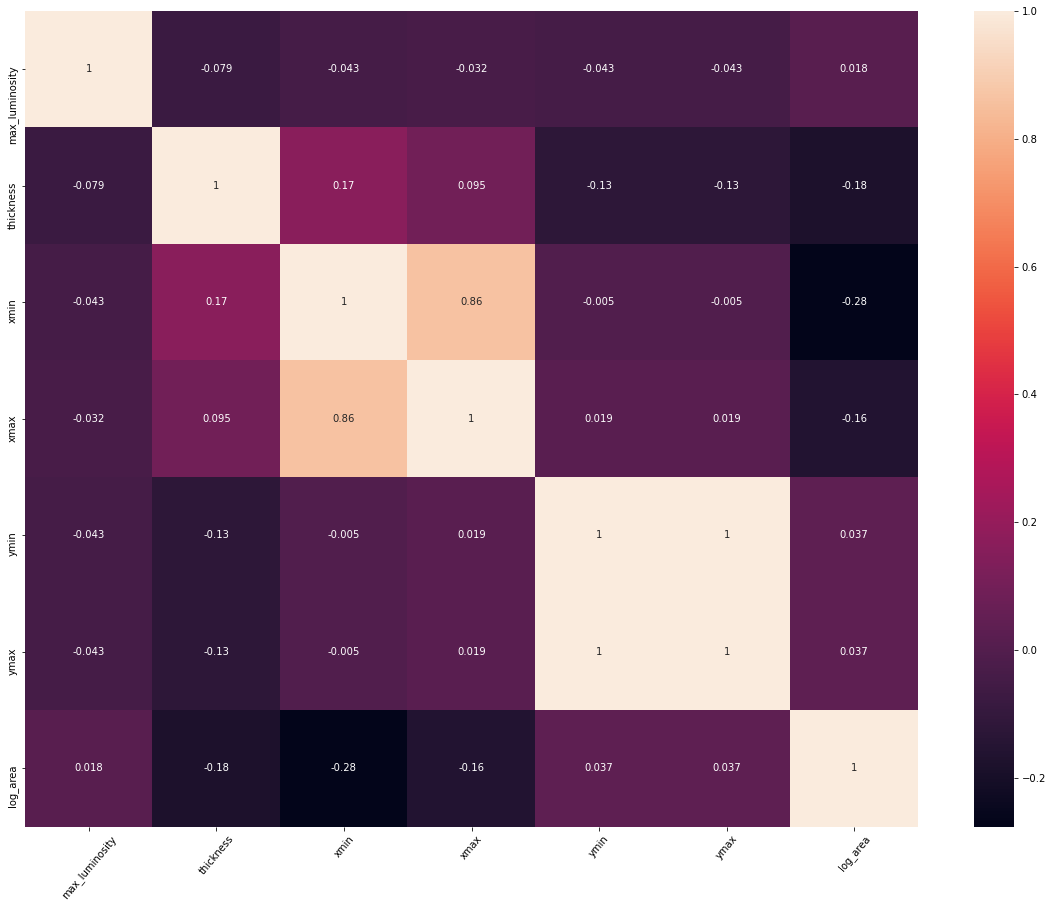

In [15]:
fd = df[['max_luminosity','thickness','xmin','xmax','ymin','ymax','log_area']]
plt.figure(figsize=(20,15))
sns.heatmap(fd.corr(method ='kendall'), xticklabels=fd.corr().columns.values,yticklabels=fd.corr().columns.values, annot=True);
plt.xticks(rotation=50)
plt.show()

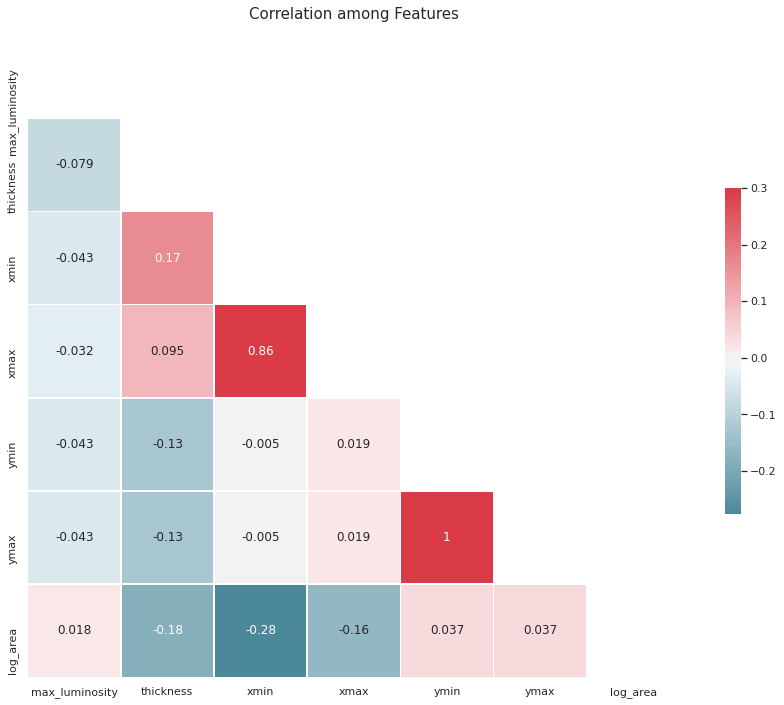

In [16]:
sns.set(style="white")
correlation = fd.corr(method ='kendall')
# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":.5}, annot=True);
plt.title("Correlation among Features",fontsize=15)
plt.show()

# Inferences from Correlation plots
1. "ymin" and "ymax" have unity correlation.
2. "Xmin" and "xmax" have near unity correlation.


In [17]:

def create_features(df):
    
    df['x_range'] = df['xmax']-df['xmin']
    df['y_range'] = df['ymax']-df['ymin']
    df['volume']= df['log_area']*df['thickness']
    
    return df

In [18]:
df = create_features(df)

In [19]:
df.drop(['ymin','xmax'],axis=1,inplace=True)
df.head()

,Grade_Component,max_luminosity,thickness,xmin,ymax,log_area,class,train_or_test,x_comp,x_range,y_range,volume
0,0,150,36,144,947332,439.099273,1.0,train,component_3,28,107,15807.573811
1,1,134,55,1144,2379624,329.205616,1.0,train,component_1,8,566,18106.308864
2,1,135,65,950,1036754,300.120598,2.0,train,component_1,24,-1688,19507.838846
3,0,123,35,41,1705604,6803.778622,1.0,train,component_3,179,24,238132.251787
4,1,138,69,462,1086579,251.401943,2.0,train,component_1,4,-1545,17346.734078


# EDA

**Univariate Analysis**

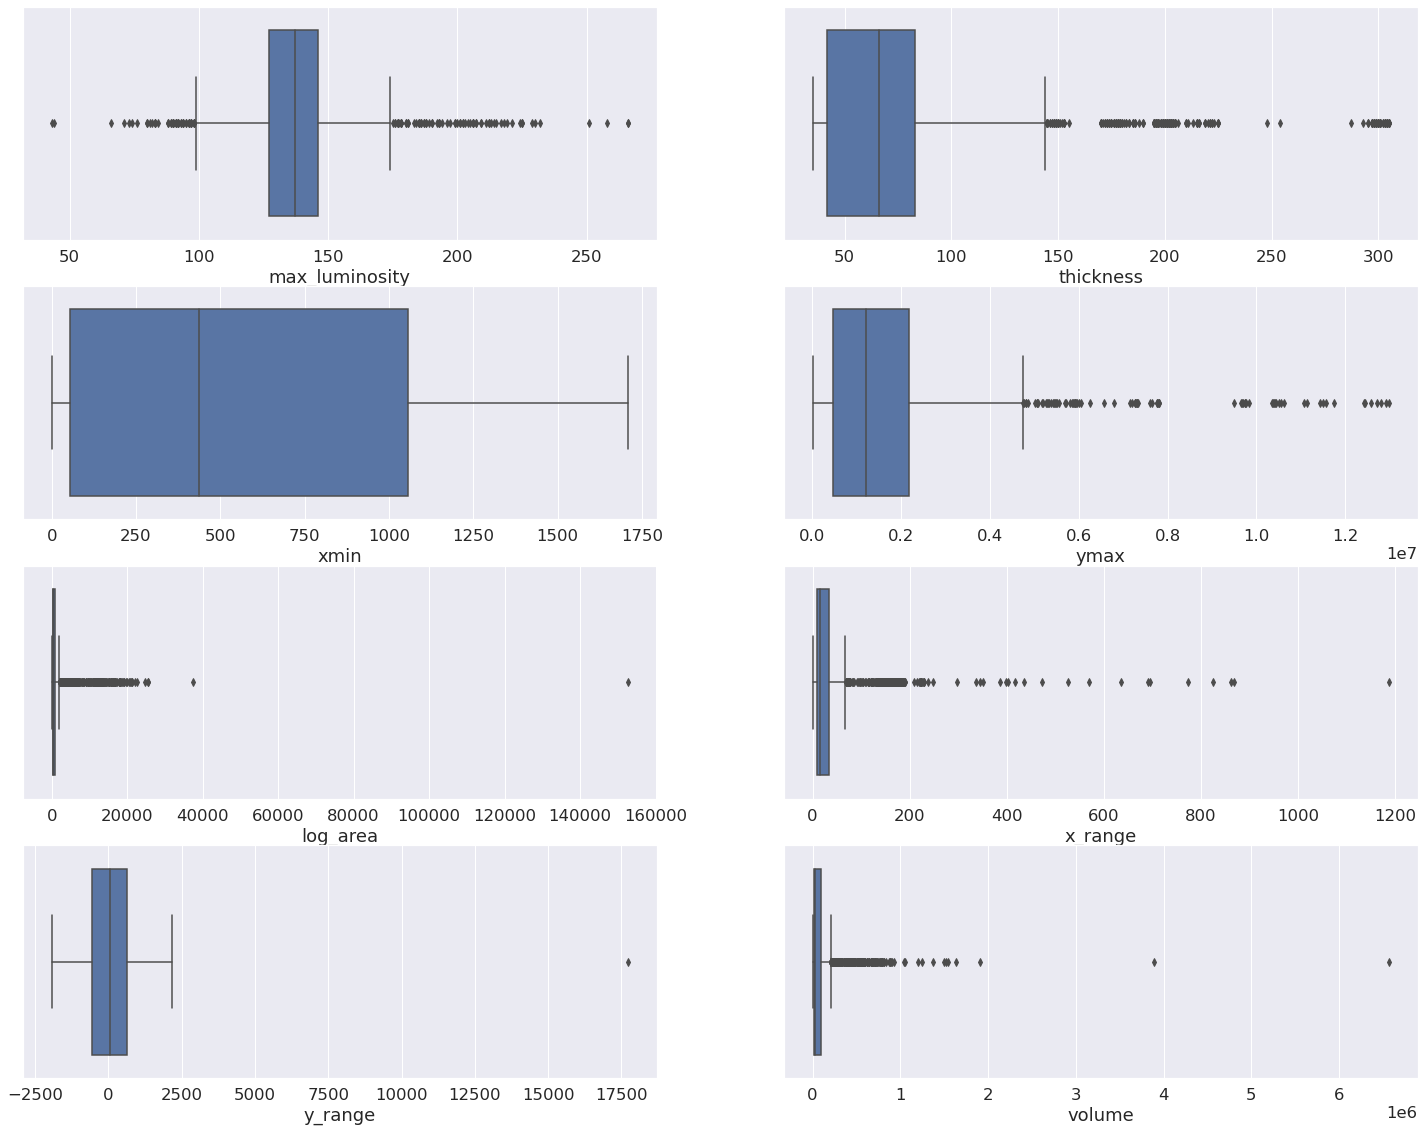

In [20]:
sns.set(rc={'figure.figsize':(25,30)},font_scale=1.5)
num_cols1=[]
for col in df.select_dtypes(['int64','float64']):
    if col not in ['class','Grade_Component']:
      num_cols1.append(col)

i = 1
for col in num_cols1:
    plt.subplot(6,2,i)
    sns.boxplot(df[col])
    i=i+1


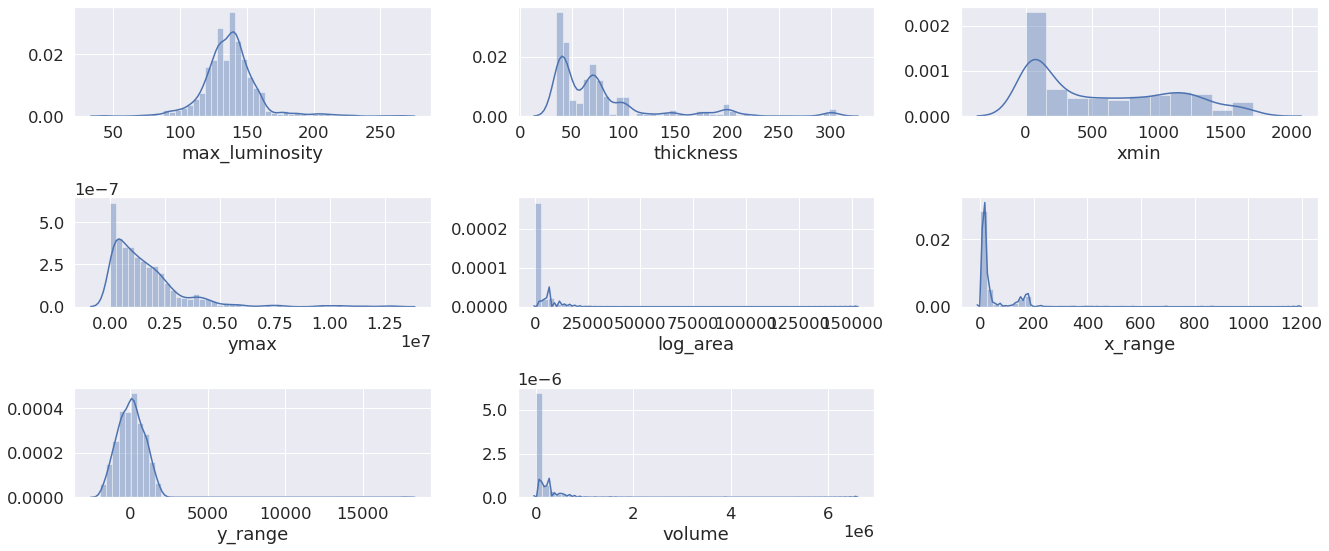

In [21]:
sns.set(rc={'figure.figsize':(19,10)},font_scale=1.5)
i = 1
for column in df[num_cols1]:
    plt.subplot(4,3,i)
    sns.distplot(df[column])
    i = i + 1
                  
plt.tight_layout()
plt.show()

## Working on log_area variable

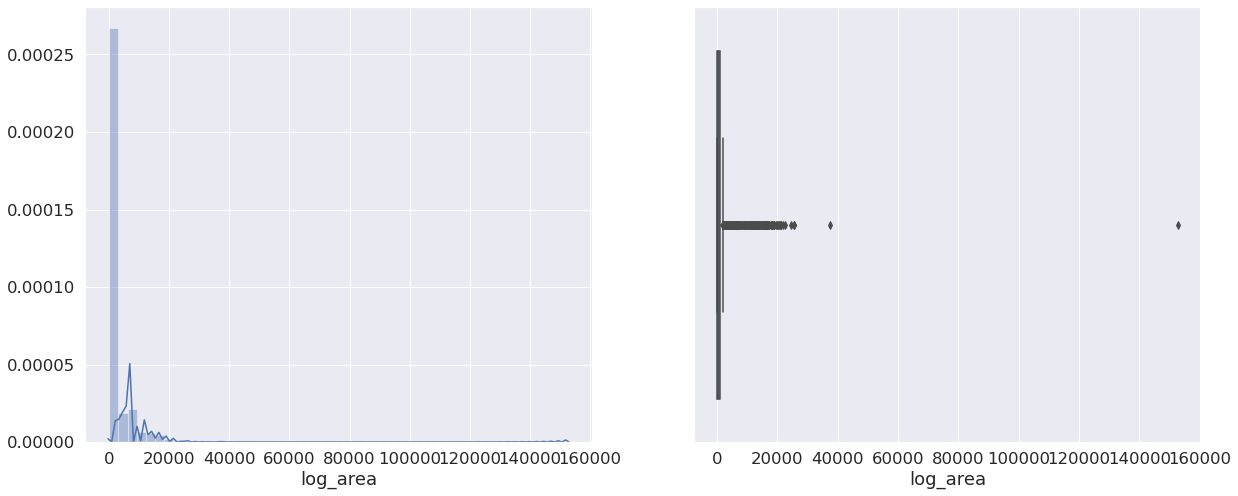

In [22]:
sns.set(rc={'figure.figsize':(20,8)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["log_area"],ax=axes[0])
sns.boxplot(df["log_area"],ax=axes[1])

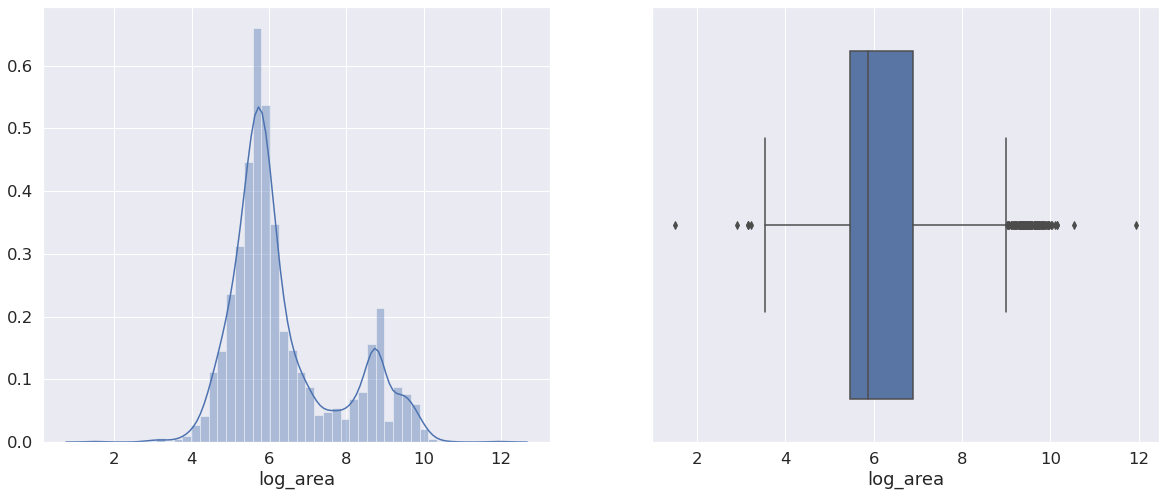

In [23]:
df['log_area'] = np.log(df["log_area"] + 1)
sns.set(rc={'figure.figsize':(20,8)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["log_area"],ax=axes[0])
sns.boxplot(df["log_area"],ax=axes[1])

## Working on ymax variable

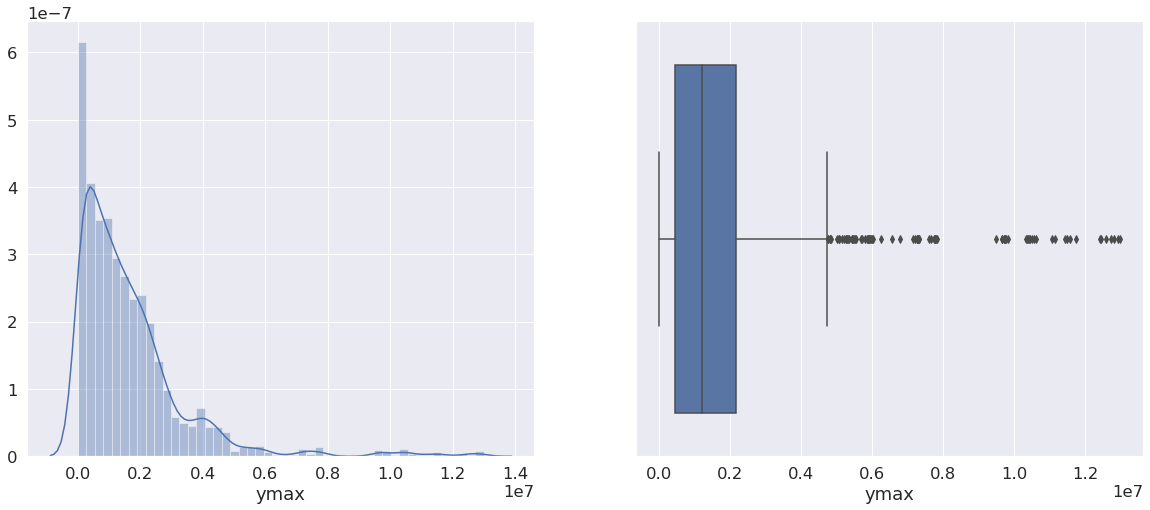

In [24]:
sns.set(rc={'figure.figsize':(20,8)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["ymax"],ax=axes[0])
sns.boxplot(df["ymax"],ax=axes[1])

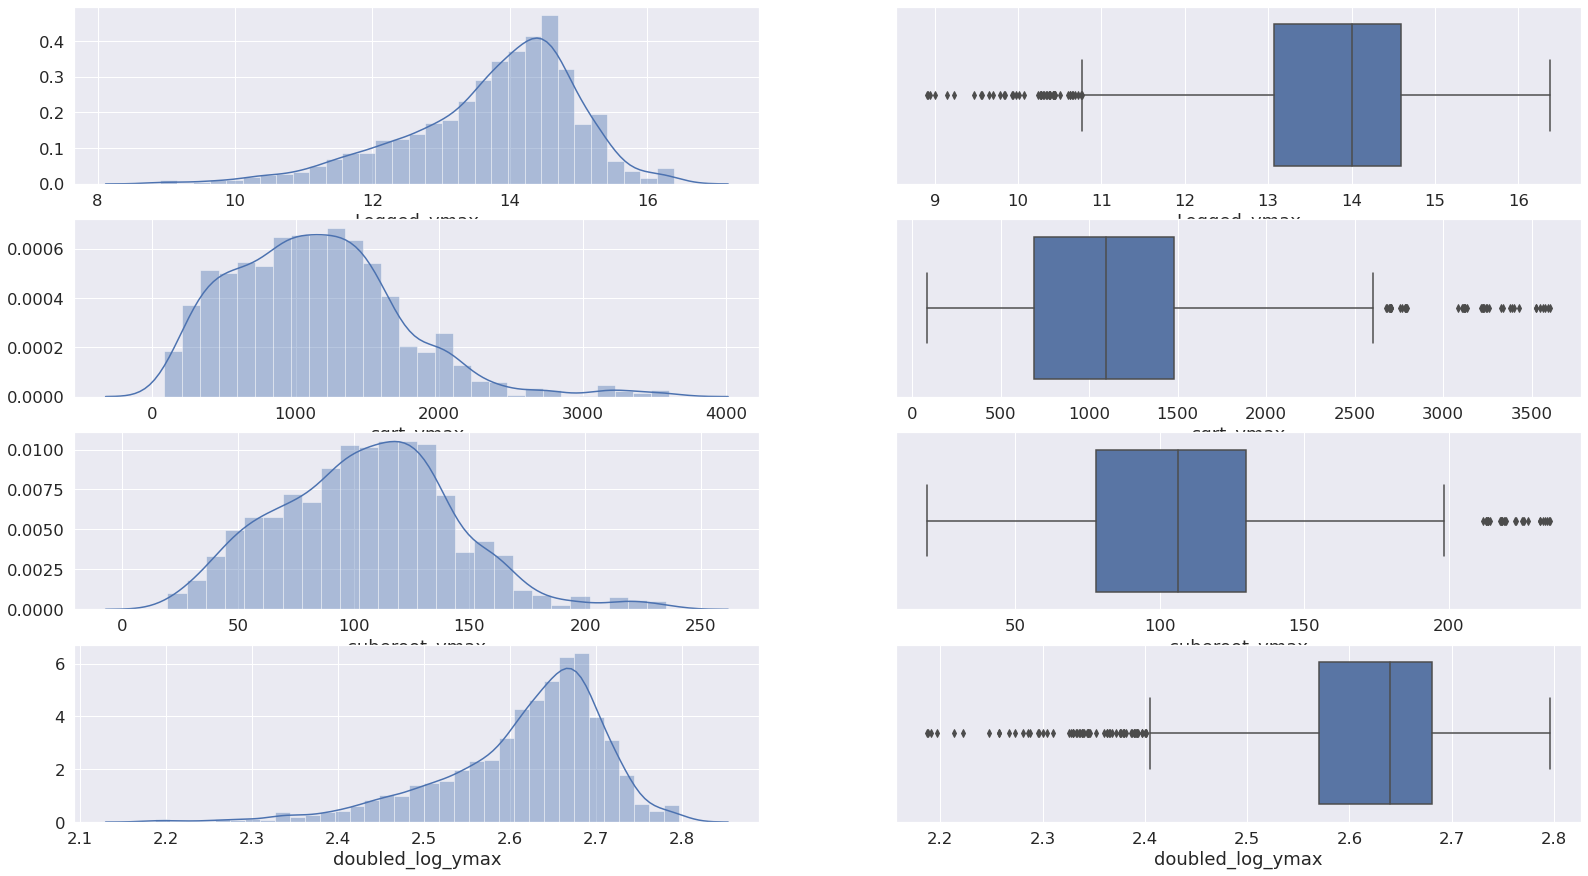

In [25]:
# Apply different Transformation and visualize usinng distplot and Boxplot
df["Logged_ymax"] = np.log(df["ymax"] + 1)
df["sqrt_ymax"] = np.sqrt(df["ymax"])
df["cuberoot_ymax"] = np.power((df["ymax"]),1/3)
df["doubled_log_ymax"] = np.log(df["Logged_ymax"])
sns.set(rc={'figure.figsize':(27,15)},font_scale=1.5)
f, axes = plt.subplots(4,2)
axes = axes.flatten()
sns.distplot(df["Logged_ymax"],ax=axes[0])
sns.boxplot(df["Logged_ymax"],ax=axes[1])
sns.distplot(df["sqrt_ymax"],ax=axes[2])
sns.boxplot(df["sqrt_ymax"],ax=axes[3])
sns.distplot(df["cuberoot_ymax"],ax=axes[4])
sns.boxplot(df["cuberoot_ymax"],ax=axes[5])
sns.distplot(df["doubled_log_ymax"],ax=axes[6])
sns.boxplot(df["doubled_log_ymax"],ax=axes[7])

In [26]:
df = df.drop(['Logged_ymax','sqrt_ymax','doubled_log_ymax','ymax'],axis = 1)
df.rename(columns={"cuberoot_ymax": "ymax"},inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 582
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Grade_Component  1941 non-null   int64   
 1   max_luminosity   1941 non-null   int64   
 2   thickness        1941 non-null   int64   
 3   xmin             1941 non-null   int64   
 4   log_area         1941 non-null   float64 
 5   class            1358 non-null   float64 
 6   train_or_test    1941 non-null   object  
 7   x_comp           1941 non-null   category
 8   x_range          1941 non-null   int64   
 9   y_range          1941 non-null   int64   
 10  volume           1941 non-null   float64 
 11  ymax             1941 non-null   float64 
dtypes: category(1), float64(4), int64(6), object(1)
memory usage: 184.1+ KB


## Working on Thickness Variable

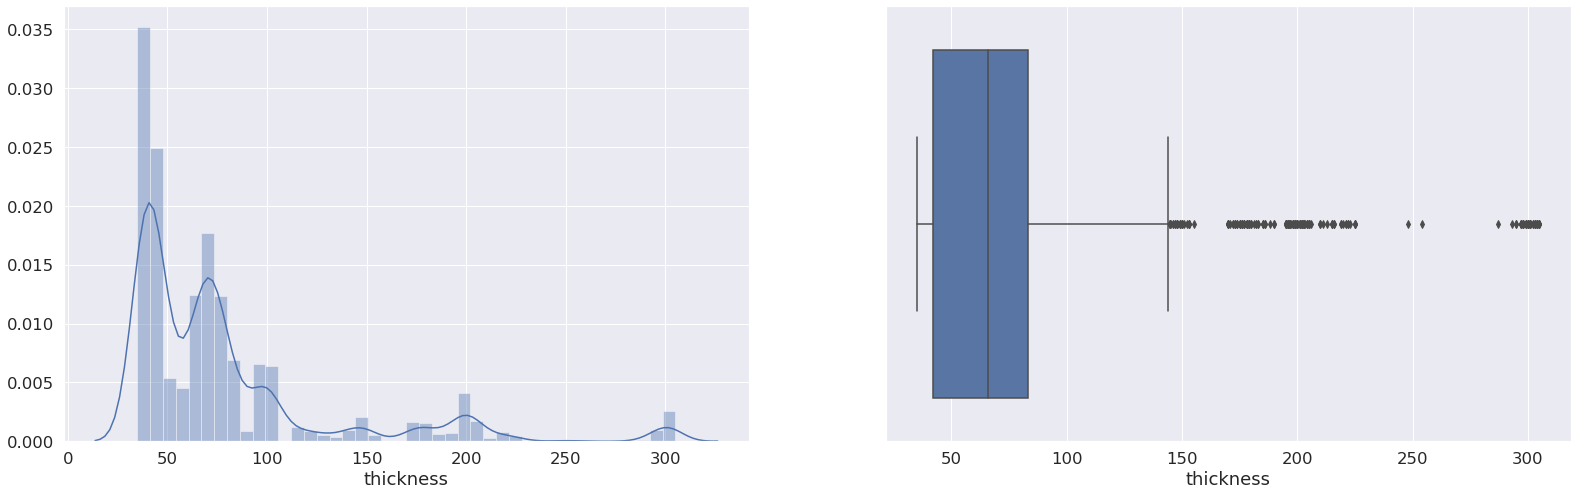

In [27]:
sns.set(rc={'figure.figsize':(27,8)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["thickness"],ax=axes[0])
sns.boxplot(df["thickness"],ax=axes[1])

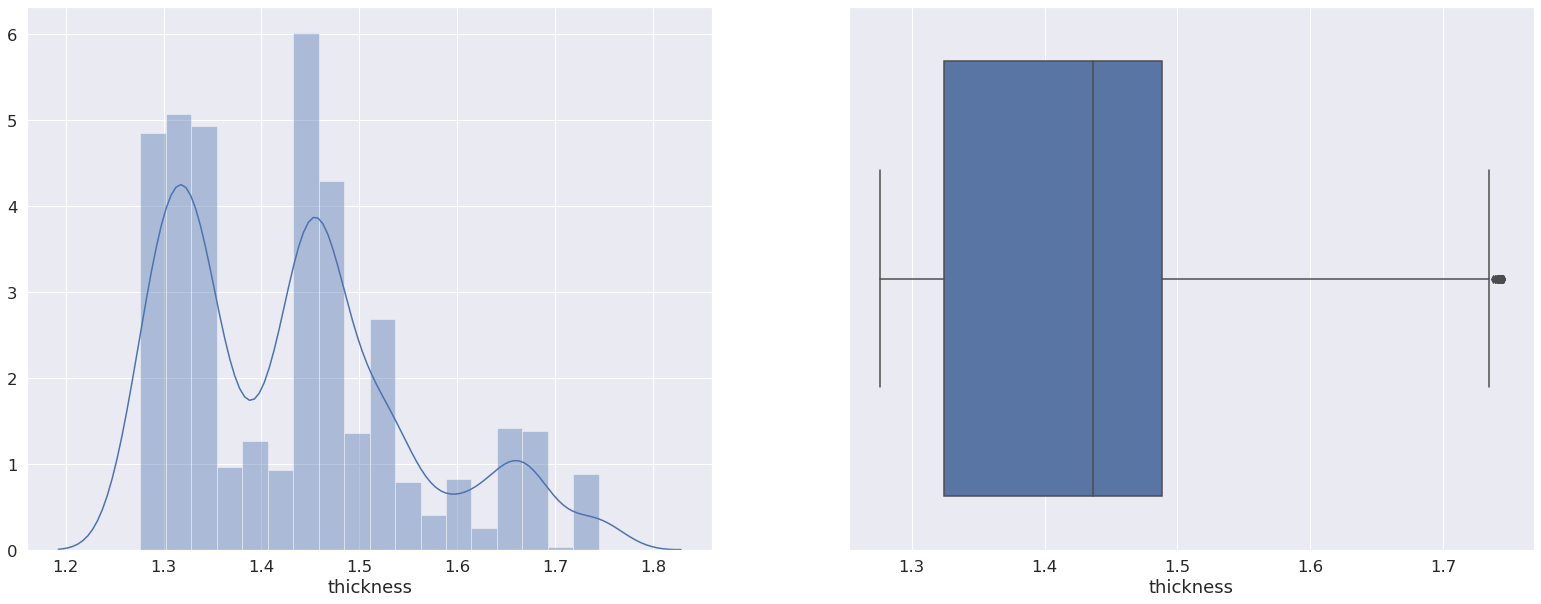

In [28]:
df["thickness"] = np.log(np.log(df["thickness"] + 1))
sns.set(rc={'figure.figsize':(27,10)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["thickness"],ax=axes[0])
sns.boxplot(df["thickness"],ax=axes[1])

## Working on Volume

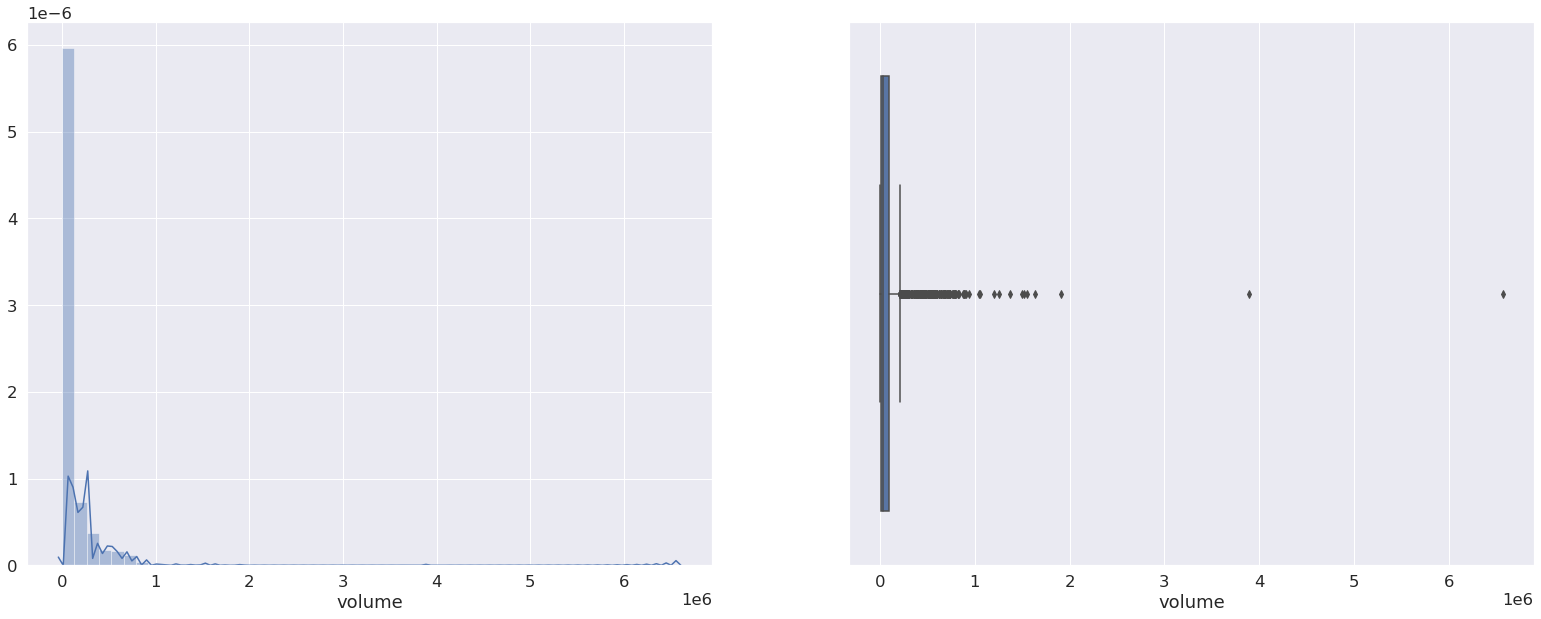

In [29]:
sns.set(rc={'figure.figsize':(27,10)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["volume"],ax=axes[0])
sns.boxplot(df["volume"],ax=axes[1])

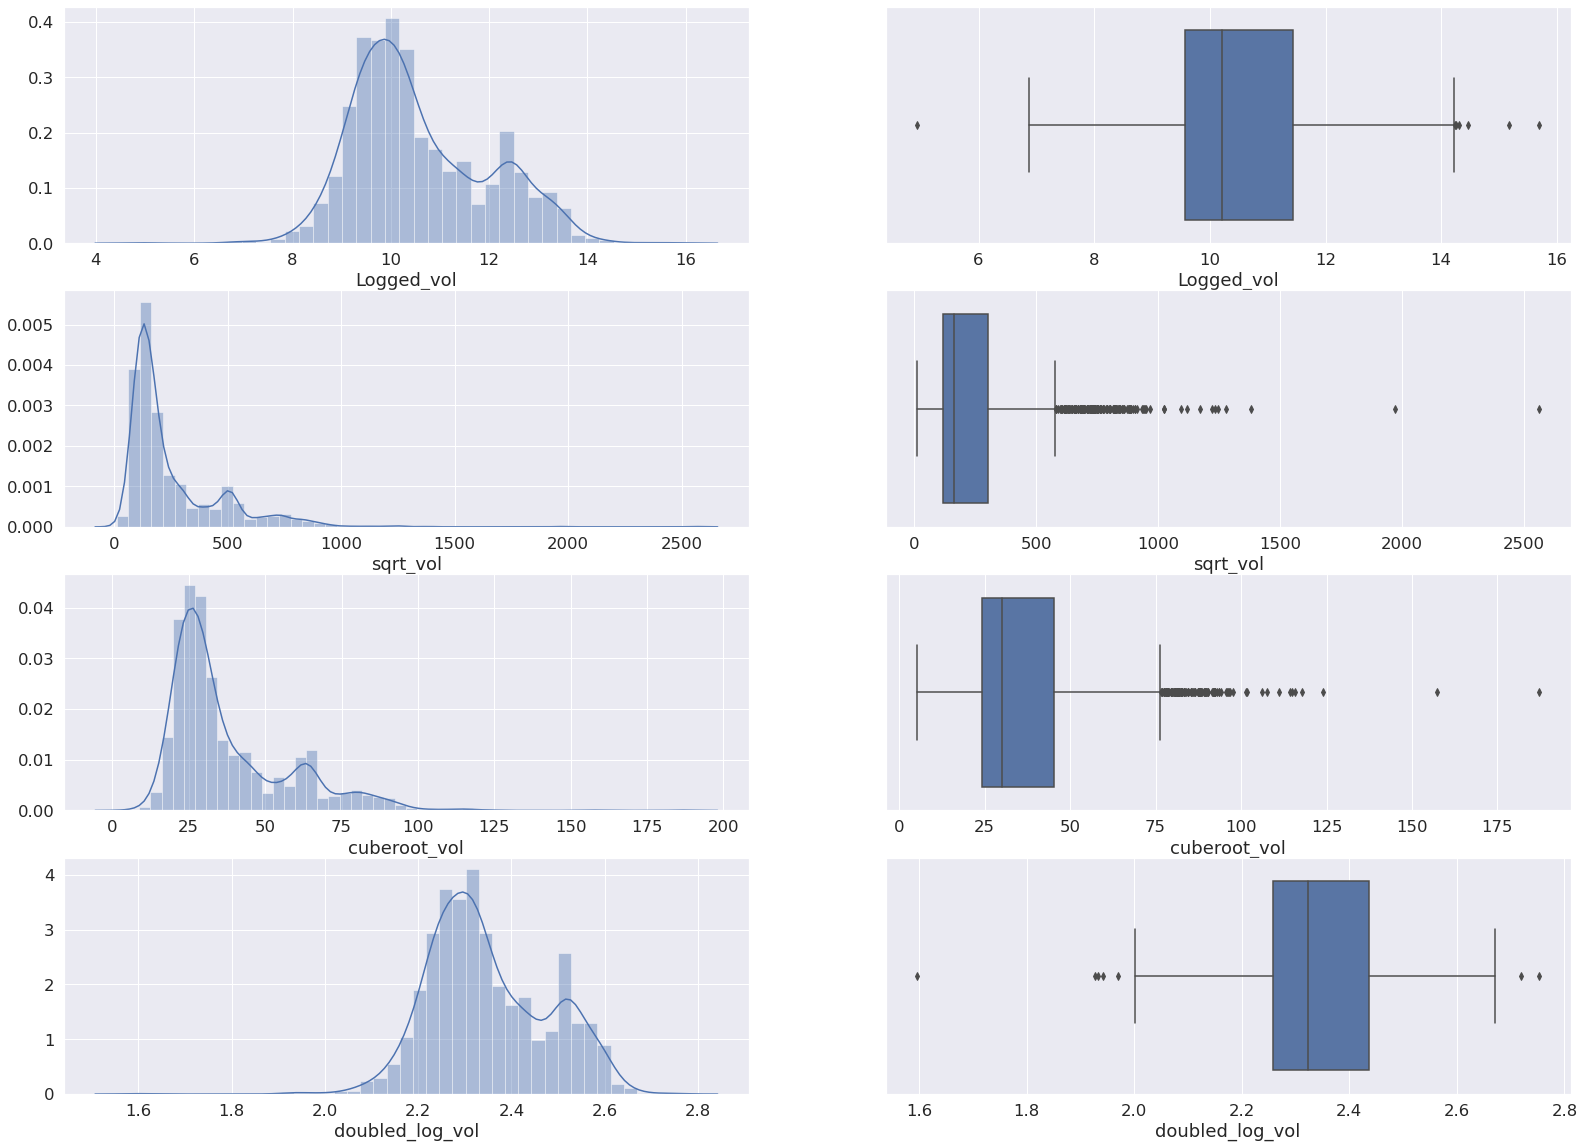

In [30]:
# Apply different Transformation and visualize usinng distplot and Boxplot
df["Logged_vol"] = np.log(df["volume"] + 1)
df["sqrt_vol"] = np.sqrt(df["volume"])
df["cuberoot_vol"] = np.power((df["volume"]),1/3)
df["doubled_log_vol"] = np.log(df["Logged_vol"])
sns.set(rc={'figure.figsize':(27,20)},font_scale=1.5)
f, axes = plt.subplots(4,2)
axes = axes.flatten()
sns.distplot(df["Logged_vol"],ax=axes[0])
sns.boxplot(df["Logged_vol"],ax=axes[1])
sns.distplot(df["sqrt_vol"],ax=axes[2])
sns.boxplot(df["sqrt_vol"],ax=axes[3])
sns.distplot(df["cuberoot_vol"],ax=axes[4])
sns.boxplot(df["cuberoot_vol"],ax=axes[5])
sns.distplot(df["doubled_log_vol"],ax=axes[6])
sns.boxplot(df["doubled_log_vol"],ax=axes[7])

In [31]:
df = df.drop(['sqrt_vol','doubled_log_vol','cuberoot_vol','volume'],axis = 1)
df.rename(columns={"Logged_vol": "volume"},inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 582
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Grade_Component  1941 non-null   int64   
 1   max_luminosity   1941 non-null   int64   
 2   thickness        1941 non-null   float64 
 3   xmin             1941 non-null   int64   
 4   log_area         1941 non-null   float64 
 5   class            1358 non-null   float64 
 6   train_or_test    1941 non-null   object  
 7   x_comp           1941 non-null   category
 8   x_range          1941 non-null   int64   
 9   y_range          1941 non-null   int64   
 10  ymax             1941 non-null   float64 
 11  volume           1941 non-null   float64 
dtypes: category(1), float64(5), int64(5), object(1)
memory usage: 184.1+ KB


## Working on Xrange 

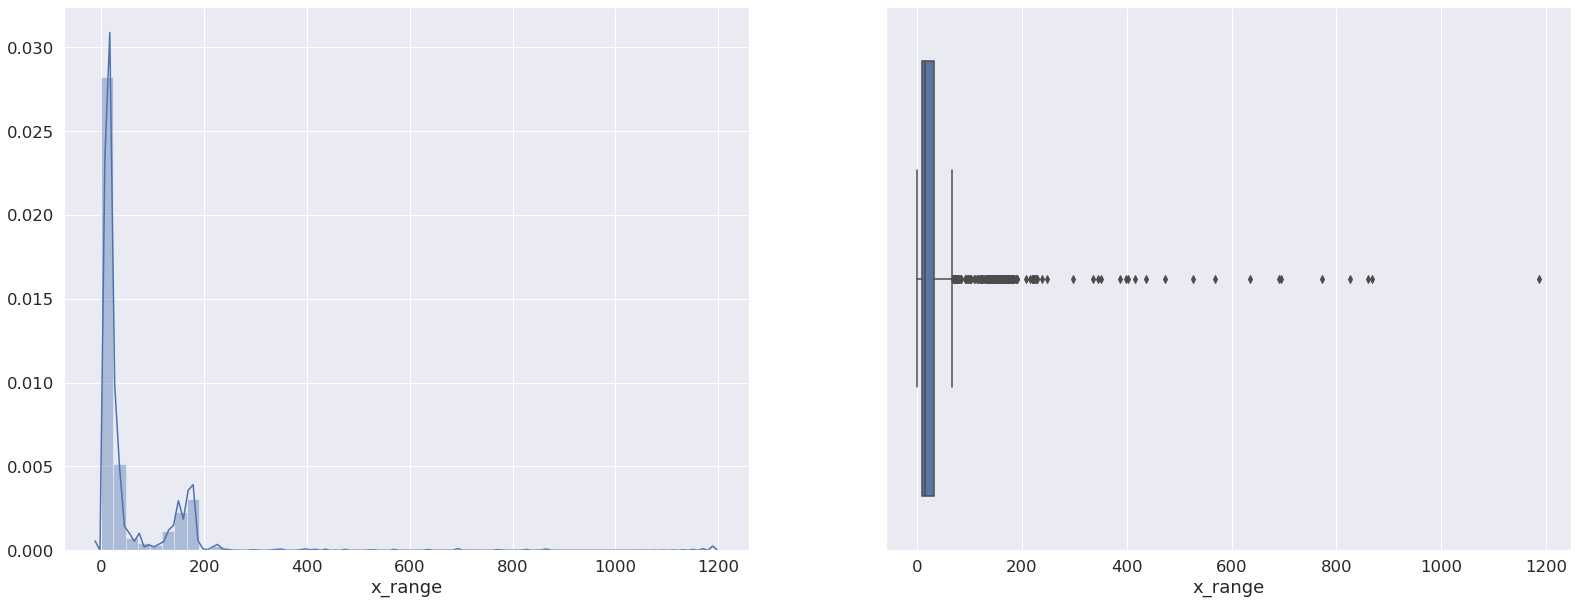

In [32]:
sns.set(rc={'figure.figsize':(27,10)},font_scale=1.5)
f, axes = plt.subplots(1,2)
axes = axes.flatten()
sns.distplot(df["x_range"],ax=axes[0])
sns.boxplot(df["x_range"],ax=axes[1])

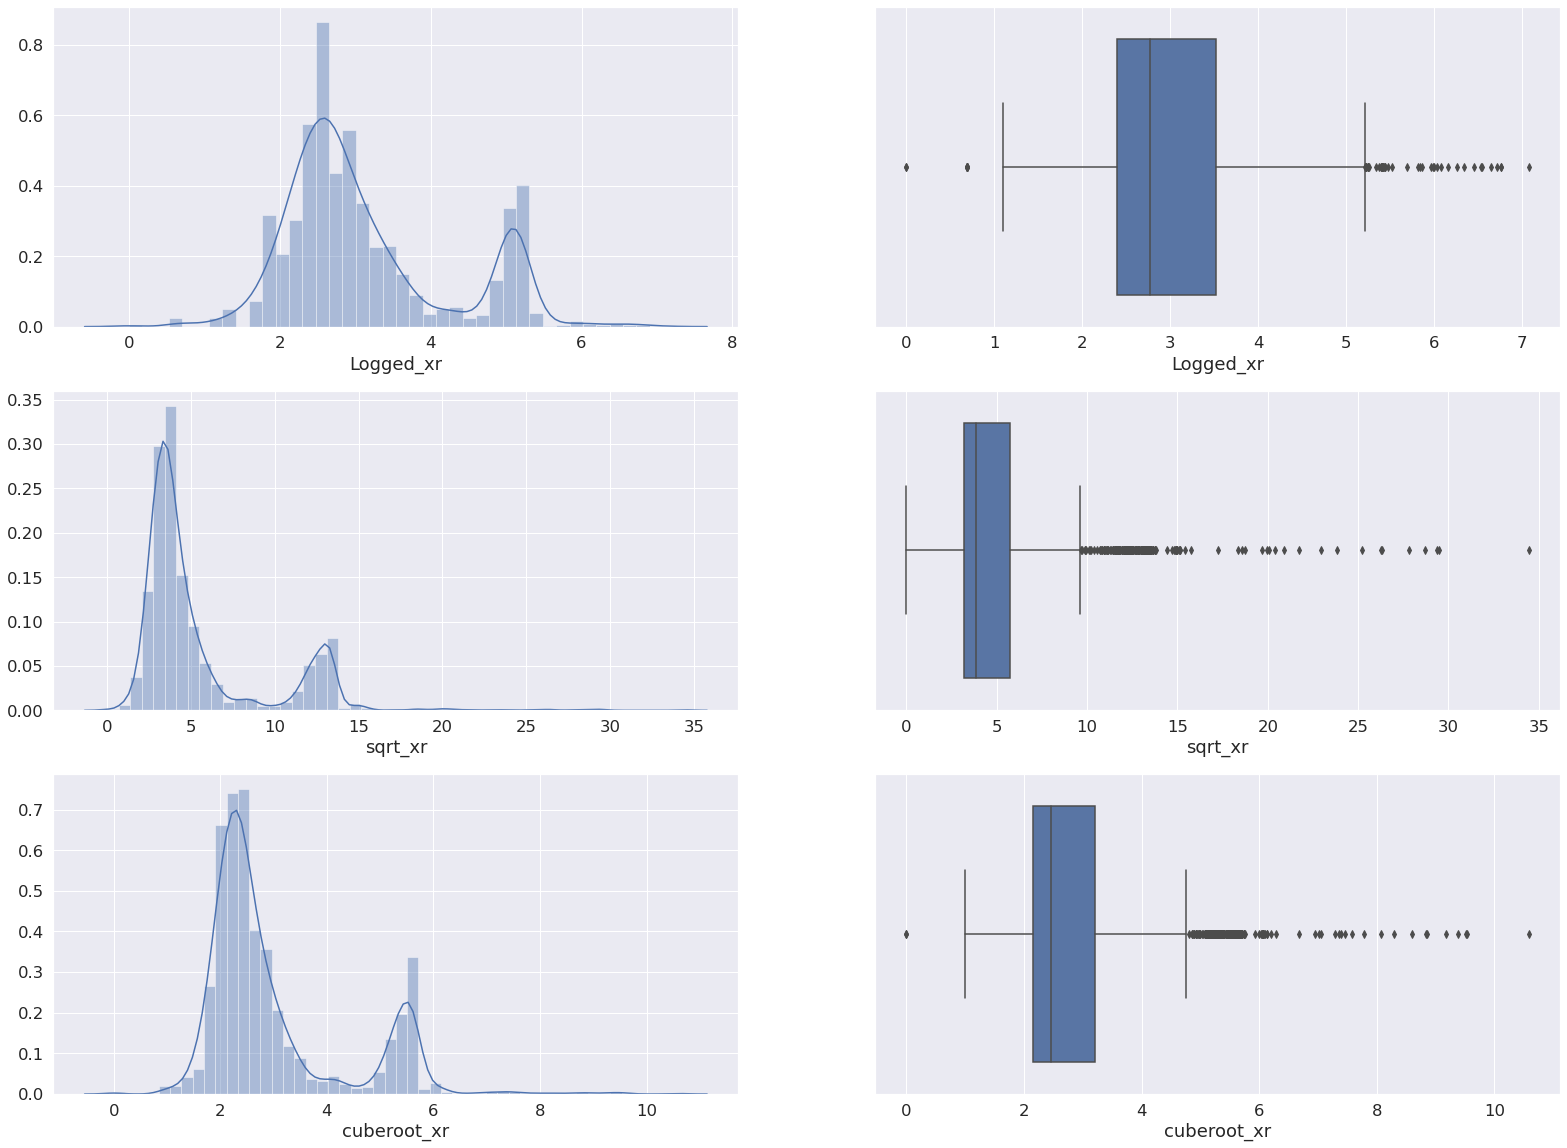

In [33]:
# Apply different Transformation and visualize usinng distplot and Boxplot
df["Logged_xr"] = np.log(df["x_range"] + 1)
df["sqrt_xr"] = np.sqrt(df["x_range"])
df["cuberoot_xr"] = np.power((df["x_range"]),1/3)
sns.set(rc={'figure.figsize':(27,20)},font_scale=1.5)
f, axes = plt.subplots(3,2)
axes = axes.flatten()
sns.distplot(df["Logged_xr"],ax=axes[0])
sns.boxplot(df["Logged_xr"],ax=axes[1])
sns.distplot(df["sqrt_xr"],ax=axes[2])
sns.boxplot(df["sqrt_xr"],ax=axes[3])
sns.distplot(df["cuberoot_xr"],ax=axes[4])
sns.boxplot(df["cuberoot_xr"],ax=axes[5])

In [34]:
df = df.drop(['sqrt_xr','cuberoot_xr','x_range'],axis = 1)
df.rename(columns={"Logged_xr": "x_range"},inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 582
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Grade_Component  1941 non-null   int64   
 1   max_luminosity   1941 non-null   int64   
 2   thickness        1941 non-null   float64 
 3   xmin             1941 non-null   int64   
 4   log_area         1941 non-null   float64 
 5   class            1358 non-null   float64 
 6   train_or_test    1941 non-null   object  
 7   x_comp           1941 non-null   category
 8   y_range          1941 non-null   int64   
 9   ymax             1941 non-null   float64 
 10  volume           1941 non-null   float64 
 11  x_range          1941 non-null   float64 
dtypes: category(1), float64(6), int64(4), object(1)
memory usage: 184.1+ KB


# Bivariate Analysis

In [35]:
num_cols1

['max_luminosity',
 'thickness',
 'xmin',
 'ymax',
 'log_area',
 'x_range',
 'y_range',
 'volume']

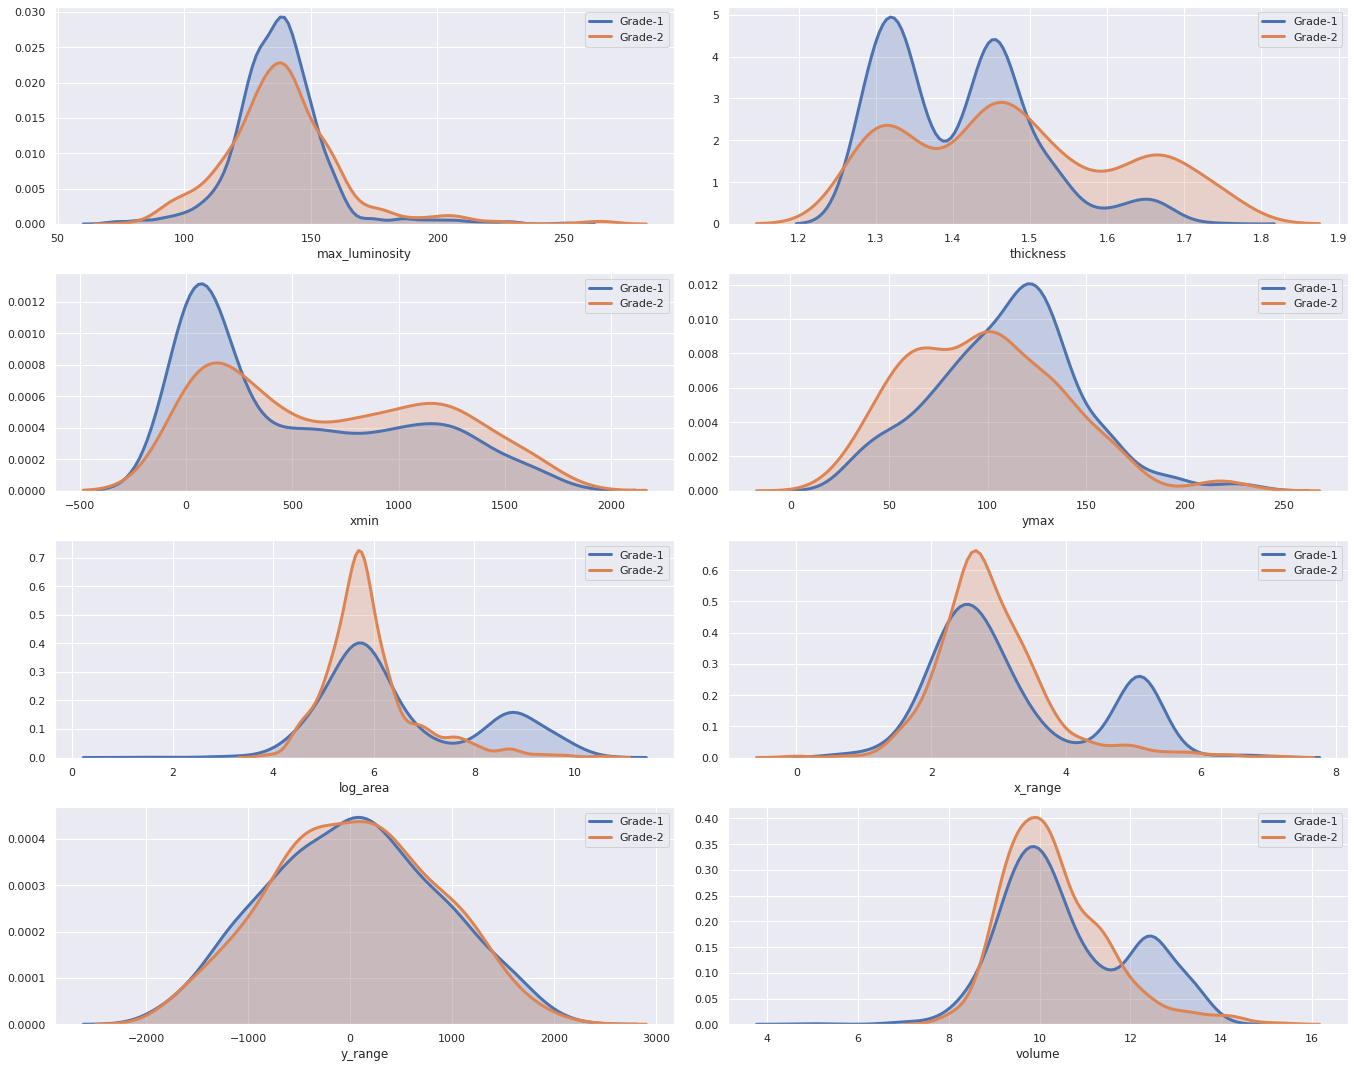

In [36]:
sns.set()
fig = plt.figure(figsize=(19,15))
i=1
for column in num_cols1:
    plt.subplot(4,2,i)
    sns.distplot(df.loc[df['class']==1,column],hist=False,kde=True,
                kde_kws={'shade': True, 'linewidth':3},
                label='Grade-1')
    sns.distplot(df.loc[df['class']==2,column],hist=False,kde=True,
                kde_kws={'shade': True, 'linewidth':3},
                label='Grade-2')
    i=i+1
plt.tight_layout()
plt.show()

## Inferences from bivariate analysis between Continous and Target variable 'Class'

1. Grade-1 glass has higher luminosity, thickness,xmin but requires lesser area.
2. Grade-2 glass has lower luminosity,thickness but higher volume and area due to higher xrange and yrange.

In [37]:
def bivariate_cat(data,col1,col2,rot):
    if col2=='class':
        cross_tab = pd.crosstab(data[col1], data[col2]).apply(lambda x: x/x.sum() * 100, axis=1).round(2)
        cross_tab.plot.bar(figsize=(12,5))
        plt.xlabel('{}'.format(col1))
        plt.ylabel('% of Glass-Type(1 or 2)'.format(col1))
        plt.title('{} Vs Glass-Type(1 or 2)'.format(col1))
        plt.xticks(rotation=rot)
        plt.show()
        return cross_tab

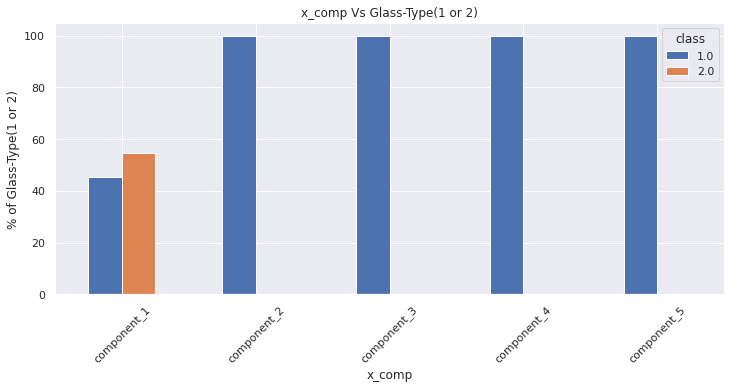

class,1.0,2.0
x_comp,,
component_1,45.23,54.77
component_2,100.00,0.00
component_3,100.00,0.00
component_4,100.00,0.00
component_5,100.00,0.00


In [38]:
bivariate_cat(df, 'x_comp','class',45)

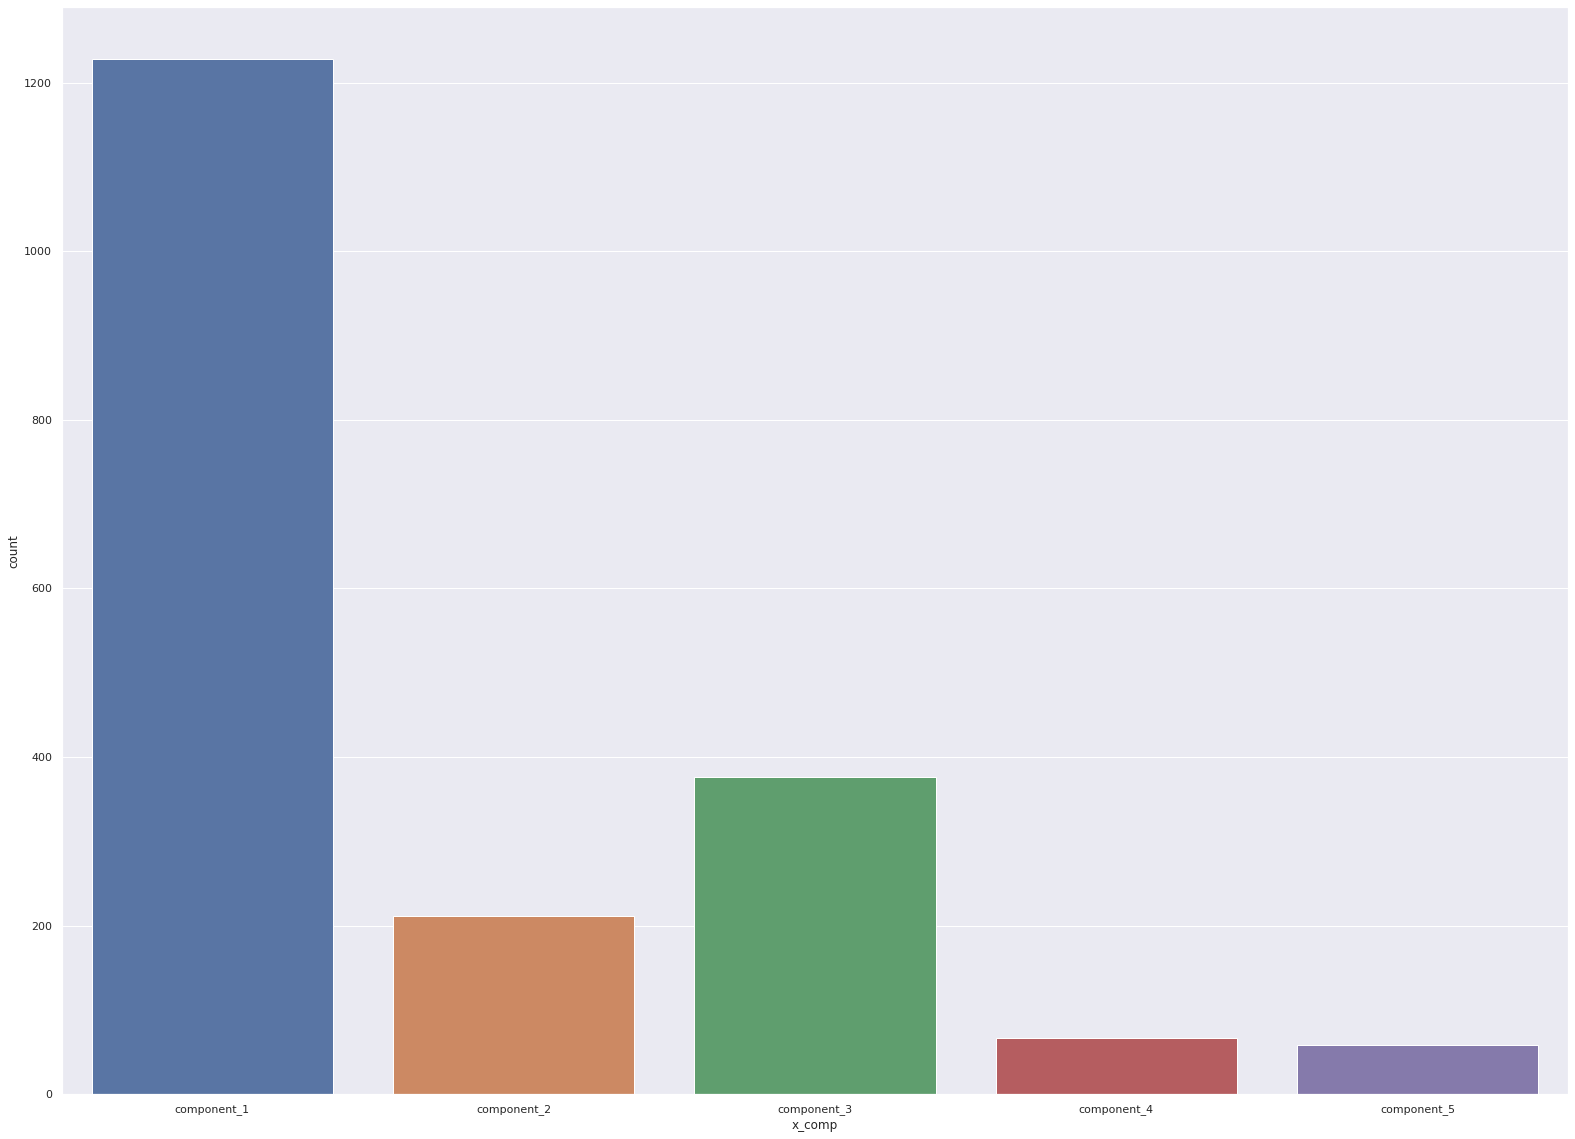

In [39]:
sns.countplot(df['x_comp'])

## Inferences from comparison from categorical variable with Target variable 'Class'

1. A very important observation for predicition is that those which have component 2,3,4 and 5 has only Glass-1 type.

In [63]:
test.head()

,max_luminosity,thickness,xmin,log_area,class,y_range,ymax,volume,x_range,xmin_per_xcomp_type,Grade_Component_0,Grade_Component_1,x_comp_component_1,x_comp_component_2,x_comp_component_3,x_comp_component_4,x_comp_component_5
0,0.423280,0.333738,0.018735,0.376117,NaN,0.120973,0.457392,0.422777,0.472354,0.019522,0,1,0,0,1,0,0
1,0.608466,0.535685,0.072600,0.330180,NaN,0.080309,0.176021,0.424604,0.317767,0.030118,1,0,1,0,0,0,0
2,0.407407,0.000000,0.036885,0.280483,NaN,0.097308,1.000000,0.256462,0.379728,0.015302,1,0,1,0,0,0,0
3,0.460317,0.061885,0.032787,0.564307,NaN,0.158430,0.223793,0.553047,0.732863,0.033897,1,0,0,0,1,0,0
4,0.523810,0.404467,0.012881,0.411364,NaN,0.055117,0.721806,0.474361,0.617834,0.005343,0,1,1,0,0,0,0


In [64]:
def confident_results(test,sub):
    for i in range(0,test.shape[0]):
        if(test['x_comp_component_2'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_comp_component_3'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_comp_component_4'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_comp_component_5'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
    return sub
    

In [41]:
df.head()

,Grade_Component,max_luminosity,thickness,xmin,log_area,class,train_or_test,x_comp,y_range,ymax,volume,x_range
0,0,150,1.283962,144,6.087000,1.0,train,component_3,107,98.212644,9.668308,3.367296
1,1,134,1.392612,1144,5.799716,1.0,train,component_1,566,133.506614,9.804071,2.197225
2,1,135,1.432618,950,5.707511,2.0,train,component_1,-1688,101.210423,9.878623,3.218876
3,0,123,1.276345,41,8.825380,1.0,train,component_3,24,119.479318,12.380586,5.192957
4,1,138,1.446565,462,5.531023,2.0,train,component_1,-1545,102.806467,9.761217,1.609438


## Generating more features based on interaction of Categorical and Continous variables

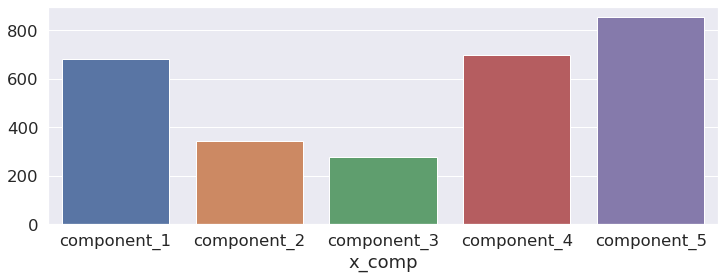

In [42]:
#lets look into xmax wrto x_comp
sns.set(rc={'figure.figsize':(12,4)},font_scale=1.5)
x = df.groupby("x_comp")["xmin"].mean().index
y= df.groupby("x_comp")["xmin"].mean().values
sns.barplot(x,y)

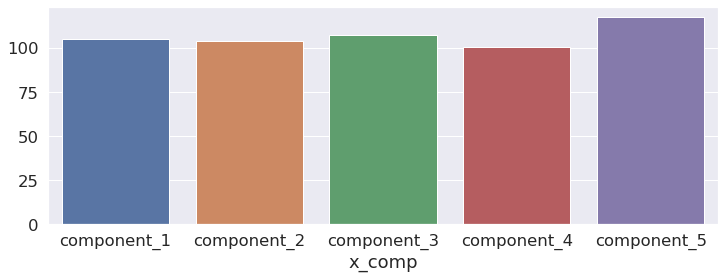

In [43]:
#lets look into xmax wrto x_comp
sns.set(rc={'figure.figsize':(12,4)},font_scale=1.5)
x = df.groupby("x_comp")["ymax"].mean().index
y= df.groupby("x_comp")["ymax"].mean().values
sns.barplot(x,y)

### I did checked the interactions of different continous variables with the categorical variable and found that only "xmin" to be included in the analysis.

In [44]:
df["xmin_per_xcomp_type"] = df["xmin"]/df.groupby(['x_comp'])['xmin'].transform('mean')

In [45]:
df.head()

,Grade_Component,max_luminosity,thickness,xmin,log_area,class,train_or_test,x_comp,y_range,ymax,volume,x_range,xmin_per_xcomp_type
0,0,150,1.283962,144,6.087000,1.0,train,component_3,107,98.212644,9.668308,3.367296,0.519045
1,1,134,1.392612,1144,5.799716,1.0,train,component_1,566,133.506614,9.804071,2.197225,1.672168
2,1,135,1.432618,950,5.707511,2.0,train,component_1,-1688,101.210423,9.878623,3.218876,1.388601
3,0,123,1.276345,41,8.825380,1.0,train,component_3,24,119.479318,12.380586,5.192957,0.147784
4,1,138,1.446565,462,5.531023,2.0,train,component_1,-1545,102.806467,9.761217,1.609438,0.675299


##  One Hot Encoding

In [46]:
#One Hot encoding
cat_cols = ["Grade_Component","x_comp"]
df= pd.get_dummies(df, columns=cat_cols)

## Differentiating test and train datasets

In [47]:
#differentiate Train and test
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

## Normalizing numerical features 

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1357
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   max_luminosity       1358 non-null   int64  
 1   thickness            1358 non-null   float64
 2   xmin                 1358 non-null   int64  
 3   log_area             1358 non-null   float64
 4   class                1358 non-null   float64
 5   y_range              1358 non-null   int64  
 6   ymax                 1358 non-null   float64
 7   volume               1358 non-null   float64
 8   x_range              1358 non-null   float64
 9   xmin_per_xcomp_type  1358 non-null   float64
 10  Grade_Component_0    1358 non-null   uint8  
 11  Grade_Component_1    1358 non-null   uint8  
 12  x_comp_component_1   1358 non-null   uint8  
 13  x_comp_component_2   1358 non-null   uint8  
 14  x_comp_component_3   1358 non-null   uint8  
 15  x_comp_component_4   1358 non-null   u

In [49]:
col = []
for features in train.select_dtypes(include=['int64','float64']):
    if features !='class':
        col.append(features)
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()
train[col] = mm.fit_transform(train[col].values)
test[col] = mm.fit_transform(test[col].values)

In [50]:
train.head()

,max_luminosity,thickness,xmin,log_area,class,y_range,ymax,volume,x_range,xmin_per_xcomp_type,Grade_Component_0,Grade_Component_1,x_comp_component_1,x_comp_component_2,x_comp_component_3,x_comp_component_4,x_comp_component_5
0,0.405128,0.016266,0.085106,0.508459,1.0,0.498780,0.365779,0.462358,0.475605,0.109422,1,0,0,0,1,0,0
1,0.323077,0.248301,0.676123,0.476671,1.0,0.610786,0.529860,0.475615,0.310341,0.352518,0,1,1,0,0,0,0
2,0.328205,0.333738,0.561466,0.466468,2.0,0.060761,0.379716,0.482894,0.454642,0.292738,0,1,1,0,0,0,0
3,0.266667,0.000000,0.024232,0.811464,1.0,0.478526,0.464648,0.727194,0.733466,0.031155,1,0,0,0,1,0,0
4,0.343590,0.363523,0.273050,0.446940,2.0,0.095656,0.387136,0.471430,0.227321,0.142363,0,1,1,0,0,0,0


In [51]:
#Getting all the model dependencies and choosing the best algorithm for optimum results
import time
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,StackingClassifier,VotingClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

!pip install catboost
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [52]:
#for getting the required evaluation metric as per the problem use---sorted(sklearn.metrics.SCORERS.keys()) to fit metric="" in the definition
def baseliner(train, features, target, cv=5, metric='neg_log_loss'):
    """
    Function for baselining Models which return CV Score, Train Score, Valid Score
    """
    print("Baseliner Models\n")
    eval_dict = {}
    models = [lgb.LGBMClassifier(), xgb.XGBClassifier(), cat.CatBoostClassifier(verbose=0), GradientBoostingClassifier(), LogisticRegression(), 
              RandomForestClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(),ExtraTreeClassifier(),ExtraTreesClassifier(),
              KNeighborsClassifier(),BaggingClassifier()
             ]
    print("Model Name \t |   CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t | %.4f \t" % (
            model_name[:12], eval_dict[model_name]['cv']))

In [53]:
target='class'
features = [i for i in train.columns if i not in ('class')]
baseliner(train,features,target)

Baseliner Models

Model Name 	 |   CV
----------------------------------------------------------------------------------------------------
LGBMClassifi 	 | -0.4178 	
XGBClassifie 	 | -0.4527 	
<catboost.co 	 | -0.3515 	
GradientBoos 	 | -0.3715 	
LogisticRegr 	 | -0.4077 	
RandomForest 	 | -0.3617 	
DecisionTree 	 | -8.5701 	
AdaBoostClas 	 | -0.5696 	
ExtraTreeCla 	 | -8.6737 	
ExtraTreesCl 	 | -0.3501 	
KNeighborsCl 	 | -0.9852 	
BaggingClass 	 | -0.5836 	


In [54]:

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# Create K_Folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

#Selecting a random based on k-folds
Y = train['class']
X = train.iloc[:,train.columns!='class']

#Split it
for train_index, test_index in kfold.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

#hyperparameter tunning for ExtraTreesClassifier
extC = ExtraTreesClassifier()

# Search grid for optimal parameters
ex_param_grid = {"max_depth":[1,3,8,15],
                 "max_features":[1,3,10,12,15],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators":[100,300,500,1000],
                 "criterion":["gini","entropy"]}

grid_extC = GridSearchCV(extC, param_grid = ex_param_grid, cv=kfold, scoring='neg_log_loss',n_jobs=4, verbose=1)
grid_extC.fit(X_train, Y_train)

extC_best = grid_extC.best_estimator_
extC_params = grid_extC.best_params_

# Best score
print("Accuracy score of ExtraTrees Classifier:",grid_extC.best_score_)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 16.4min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 21.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 26.7min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 32.9min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 41.0min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 47.3min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 54.1min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 62.0mi

Accuracy score of ExtraTrees Classifier: -0.33653916688994295


In [55]:
extC_params

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [66]:
extC_best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=15, max_features=15,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [59]:
model = ExtraTreesClassifier(bootstrap = False,criterion = 'gini', max_depth = 15,max_features = 15,
                             min_samples_leaf=1,min_samples_split=2,n_estimators = 500)
model.fit(train[features],train[target])
y_pred = model.predict_proba(test[features])
sub = pd.DataFrame(y_pred,columns=[1,2])

In [65]:
sub = confident_results(test,sub)
sub.to_excel("extratrees_addv1.xls",index=False)

In [ ]:
############################################    Thank You     #########################################